In [1]:
# Import the required modules
import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['font.size'] = 8
import tensorflow as tf

import warnings
warnings.simplefilter('ignore')

In [2]:
PATH_DATASET = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset'

In [3]:
imgTrainGen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 45,
    zoom_range = 0.2,
    shear_range = 0.2,
    featurewise_center = True,
    featurewise_std_normalization = True,
    width_shift_range = 0,
    height_shift_range = 0,
    vertical_flip = False,
    validation_split = 0.2,
    fill_mode = 'nearest'
)

imgTestGen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split = 0.2
)


trainGeneratorBuild = imgTrainGen.flow_from_directory(
    PATH_DATASET,
    subset = 'training',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32
)

testGeneratorBuild = imgTestGen.flow_from_directory(
    PATH_DATASET,
    subset = 'validation',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32
)

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [4]:
from tensorflow.keras import layers

inp = layers.Input(shape=(224,224,3))
pretrained_base = tf.keras.applications.EfficientNetB7(
    include_top = False,
    input_shape = (224, 224, 3),
    input_tensor = inp,
    weights = 'imagenet'
)
pretrained_base.trainable = False

top_conv = pretrained_base.get_layer('top_conv')
x = tf.keras.layers.GlobalAveragePooling2D()(top_conv.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(inputs = inp, outputs = x)
model.summary()

258080768/258076736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
___________________________

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = ModelCheckpoint('model.hdf5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

es = EarlyStopping(verbose=1, patience=5)

In [6]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics='accuracy'
)

start = datetime.datetime.now()
history = model.fit(trainGeneratorBuild,
                    epochs = 15, 
                    validation_data = testGeneratorBuild,
                    workers = 8, 
                    verbose = 1,
                    callbacks = [mcp, es, lrd]
                    )

end = datetime.datetime.now()
print(f'Total Training Time: {end - start}')

Epoch 1/15
530/530 [==============================] - 260s 441ms/step - loss: 1.1821 - accuracy: 0.6629 - val_loss: 0.5387 - val_accuracy: 0.7975

Epoch 00001: val_loss improved from inf to 0.53867, saving model to model.hdf5
Epoch 2/15
530/530 [==============================] - 230s 428ms/step - loss: 0.6314 - accuracy: 0.7650 - val_loss: 0.4626 - val_accuracy: 0.8204

Epoch 00002: val_loss improved from 0.53867 to 0.46258, saving model to model.hdf5
Epoch 3/15
530/530 [==============================] - 227s 424ms/step - loss: 0.6218 - accuracy: 0.7695 - val_loss: 0.5055 - val_accuracy: 0.8197

Epoch 00003: val_loss did not improve from 0.46258
Epoch 4/15
530/530 [==============================] - 227s 423ms/step - loss: 0.5804 - accuracy: 0.7821 - val_loss: 0.4359 - val_accuracy: 0.8358

Epoch 00004: val_loss improved from 0.46258 to 0.43585, saving model to model.hdf5
Epoch 5/15
530/530 [==============================] - 227s 423ms/step - loss: 0.5551 - accuracy: 0.7999 - val_loss: 

In [7]:
model.load_weights('./model.hdf5')

In [8]:
model.save('full_covid_model.h5')

In [ ]:
## Kaggle shows Resource Exhausted :(
## Exported model, will run in different notebook (post hackathon)
## For now 85% seems good enough 
#pretrained_base.trainable = True
#model.compile(
#    optimizer = tf.keras.optimizers.Adam(0.00001),
#    loss='categorical_crossentropy',
#    metrics='accuracy'
#)
#fine_history = model.fit(trainGeneratorBuild,
#                         epochs = 5, 
#                         validation_data = testGeneratorBuild,
#                         workers = 8, 
#                         verbose = 1)

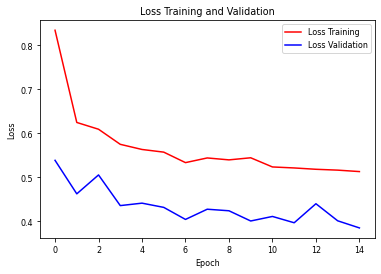

In [10]:
plt.plot(history.history['loss'], 'r', label='Loss Training')
plt.plot(history.history['val_loss'], 'b', label='Loss Validation')
plt.title('Loss Training and Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [12]:
img_path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/COVID-1002.png'

In [13]:
import cv2
img = cv2.imread(img_path)
#image size
size=(1,224,224,3)
#resize image
img.resize(size)

preds = model.predict(img)

print(preds)

[[9.9812788e-01 1.7737431e-03 7.9373043e-05 1.9044352e-05]]


In [19]:
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import Model


def VizGradCAM(model, image, interpolant=0.5, plot_results=True):
    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    # Sanity Check
    assert (
        interpolant > 0 and interpolant < 1
    ), "Heatmap Interpolation Must Be Between 0 - 1"

    last_conv_layer = next(
        x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D)
    )
    target_layer = model.get_layer(last_conv_layer.name)

    original_img = image
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)

    # Obtain Prediction Index
    prediction_idx = np.argmax(prediction)

    # Compute Gradient of Top Predicted Class
    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        # Obtain the Prediction Loss
        loss = prediction[:, prediction_idx]

    # Gradient() computes the gradient using operations recorded
    # in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    # Obtain the Output from Shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    # Obtain Depthwise Mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    # Create a 7x7 Map for Aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    # Multiply Weights with Every Layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    # Resize to Size of Image
    activation_map = cv2.resize(
        activation_map.numpy(), (original_img.shape[1], original_img.shape[0])
    )

    # Ensure No Negative Numbers
    activation_map = np.maximum(activation_map, 0)

    # Convert Class Activation Map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (
        activation_map.max() - activation_map.min() + .00001
    )
    activation_map = np.uint8(255 * activation_map)

    # Convert to Heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    # Superimpose Heatmap on Image Data
    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min() + .0001)
        * 255
    )

    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Enlarge Plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(
            np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))
        )
        
        plt.savefig('covid.png')
    else:
        return cvt_heatmap

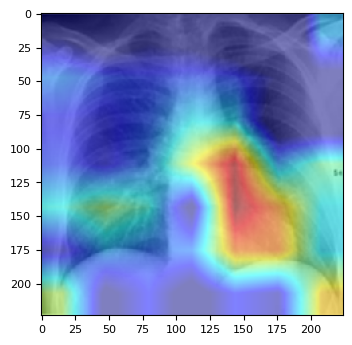

In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load Your Favourite Image
test_img = img_to_array(load_img(img_path , target_size=(224,224)))

# Use The Function - Boom!
VizGradCAM(model, test_img)